# Final Project for IANNwTF 2022/23 


Learning to colorize grayscale dog pictures with the Stanford Dog Dataset.  

In [129]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorboard
from PIL import Image
import os
from datetime import datetime
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle
from keras.layers import Dense, Conv2D, Reshape, GlobalAveragePooling2D, MaxPooling2D, UpSampling2D, Flatten


In [130]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [131]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [132]:
# get data
train_ds,  test_ds = tf.keras.utils.image_dataset_from_directory(directory="data/Images", label_mode="categorical", batch_size=None, shuffle=False, image_size=(128,128), validation_split=0.1, subset="both", crop_to_aspect_ratio=True)
print(train_ds.class_names)
class_names = train_ds.class_names
normalizing_layer = tf.keras.layers.Rescaling(1./255)
flip_layer = tf.keras.layers.RandomFlip()
rotation_layer = tf.keras.layers.RandomRotation((-0.1,0.1))


def print_x(x):
    print(x)
    print(tf.reduce_min(x), tf.reduce_max(x))
    return(x)

def preprocess_train(data):

    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (flip_layer(x), y))
    data = data.map(lambda x,y: (rotation_layer(x), y))

    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))
    data = data.map(lambda image, label: (((print_x(tf.expand_dims((image[:,:,0]/200 + 0.5), -1)), print_x(((image[:,:,1:]/200) + 0.5)))), print_x(label)))
    #data = data.map(lambda image, label: ((((tf.expand_dims(image[:,:,0], -1))/100, ((image[:,:,1:]/256) + 0.5))), tf.one_hot(print_x(label), 120)))

    data = data.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

    return data

def preprocess_test(data):
    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))

    data = data.map(lambda image, label: (((print_x(tf.expand_dims((image[:,:,0]/200 + 0.5), -1)), print_x(((image[:,:,1:]/200) + 0.5)))), print_x(label)))

    data = data.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

    return data

train_data = preprocess_train(train_ds)
test_data = preprocess_test(test_ds)

Found 20580 files belonging to 120 classes.
Using 18522 files for training.
Using 2058 files for validation.
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier'

In [133]:
sample_image = imread("data/Images/n02099712-Labrador_retriever/n02099712_1200.jpg")/255
sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
#imshow(sample_image)
print(sample_image)
sample_image = tfio.experimental.color.rgb_to_lab(sample_image)
print(sample_image)
print(tf.reduce_min(sample_image[0]), tf.reduce_max(sample_image[0]))
print(tf.reduce_min(sample_image[1]), tf.reduce_max(sample_image[1]))
print(tf.reduce_min(sample_image[2]), tf.reduce_max(sample_image[2]))


tf.Tensor(
[[[0.00784314 0.01568628 0.        ]
  [0.03137255 0.03921569 0.        ]
  [0.52156866 0.5411765  0.4627451 ]
  ...
  [0.27450982 0.2627451  0.09411765]
  [0.98039216 0.9647059  0.7882353 ]
  [0.3647059  0.3372549  0.15686275]]

 [[0.01568628 0.01960784 0.        ]
  [0.02745098 0.03529412 0.        ]
  [0.01960784 0.03921569 0.        ]
  ...
  [0.07450981 0.06666667 0.        ]
  [0.8156863  0.79607844 0.6313726 ]
  [0.6745098  0.65882355 0.48235294]]

 [[0.05882353 0.0627451  0.03921569]
  [0.03137255 0.03921569 0.        ]
  [0.07843138 0.09411765 0.02745098]
  ...
  [0.627451   0.6156863  0.4862745 ]
  [0.3764706  0.36862746 0.21960784]
  [0.57254905 0.5568628  0.40784314]]

 ...

 [[0.54509807 0.47058824 0.40392157]
  [1.         0.94509804 0.8666667 ]
  [1.         0.9882353  0.9098039 ]
  ...
  [0.627451   0.5058824  0.43529412]
  [0.47058824 0.34117648 0.27450982]
  [0.41960785 0.2901961  0.21568628]]

 [[0.76862746 0.69803923 0.61960787]
  [1.         0.9882353  0

In [134]:
class Low_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_1 = tf.keras.layers.BatchNormalization()
        self.conv2 = Conv2D(128, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_2 = tf.keras.layers.BatchNormalization()
        self.conv3 = Conv2D(128, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_3 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(256, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_4 = tf.keras.layers.BatchNormalization() 
        self.conv5 = Conv2D(256, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_5 = tf.keras.layers.BatchNormalization() 
        self.conv6 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_6 = tf.keras.layers.BatchNormalization() 

    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv3(x)
        x = self.batchnorm_3(x, training)
        x = self.conv4(x)
        x = self.batchnorm_4(x, training)
        x = self.conv5(x)
        x = self.batchnorm_5(x, training)
        x = self.conv6(x)
        x = self.batchnorm_6(x, training)

        return x

In [135]:
class Mid_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(512, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_1 = tf.keras.layers.BatchNormalization()

        self.conv2 = Conv2D(256, 3, activation='relu', padding='same', strides=1) 
        self.batchnorm_2 = tf.keras.layers.BatchNormalization()


    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.batchnorm_1(x, training)

        x = self.conv2(x)
        x = self.batchnorm_2(x, training)

        return x

In [136]:
class High_Level_Features(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(512, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_1 = tf.keras.layers.BatchNormalization() 
        self.conv2 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_2 = tf.keras.layers.BatchNormalization() 
        self.conv3 = Conv2D(512, 3, activation='relu', padding='same', strides=2)
        self.batchnorm_3 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(512, 3, activation='relu', padding='same', strides=1)
        self.batchnorm_4 = tf.keras.layers.BatchNormalization() 
        self.flatten = Flatten()
        self.dense1 = Dense(1024, activation="relu")
        self.dense2 = Dense(512, activation="relu")
        self.dense3 = Dense(256, activation="relu")

    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv3(x)
        x = self.batchnorm_3(x, training)
        x = self.conv4(x)
        x = self.batchnorm_4(x, training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)

        return x

In [137]:
class Classification_Layers(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(256, activation="relu")
        self.dense2 = Dense(120, activation="softmax")

    def __call__(self, x, training=False):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [138]:
class Fusion_Layer(tf.keras.Model):
    def __init__(self):
        super().__init__()
        #32,256,256
        #

        self.repeat_layer = tf.keras.layers.RepeatVector(32*32)
        self.reshape = tf.keras.layers.Reshape(([32,32,256]))
        self.concat = tf.keras.layers.Concatenate(axis=3)
        self.conv = Conv2D(256, kernel_size=1,strides=1, activation="relu", padding="same")


    def __call__(self, mid_level, global_vector, training=False):
        x = self.repeat_layer(global_vector) 
        x = self.reshape(x)
        x = self.concat([mid_level, x]) 
        x = self.conv(x)

        return x 


In [139]:
class Colorization_Layers(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(128, 3, activation='relu', padding='same', strides=1) 
        self.upsampling1 = UpSampling2D(2)
        self.batchnorm_1 = tf.keras.layers.BatchNormalization() 
        self.conv2 = Conv2D(64, 3, activation='relu', padding='same', strides=1) 
        self.conv3 = Conv2D(64, 3, activation='relu', padding='same', strides=1)
        self.upsampling2 = UpSampling2D(2) 
        self.batchnorm_2 = tf.keras.layers.BatchNormalization() 
        self.conv4 = Conv2D(32, 3, activation='relu', padding='same', strides=1)
        self.conv5 = Conv2D(2, 3, activation='sigmoid', padding='same', strides=1) 

    def __call__(self, input, training=False):
        x = self.conv1(input)
        x = self.upsampling1(x)
        x = self.batchnorm_1(x, training)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsampling2(x)
        x = self.batchnorm_2(x, training)
        x = self.conv4(x)
        x = self.conv5(x)

        return x


In [140]:
class Colorization_Network(tf.keras.Model):
    def __init__(self, low_level):
        super().__init__()
        self.low_level = low_level
        self.mid_level = Mid_Level_Features()
        self.fusion = Fusion_Layer()
        self.colorization = Colorization_Layers()


    def call(self, input, high_level_input, training=False):
        low = self.low_level(input, training)
        middle = self.mid_level(low, training)
        fused = self.fusion(middle, high_level_input, training)
        colored = self.colorization(fused, training)
        return colored



In [141]:
class Classification_Network(tf.keras.Model):
    def __init__(self, low_level):
        super().__init__()
        self.low_level = low_level 
        self.high_level = High_Level_Features()

        self.classification = Classification_Layers()




    def call(self, input, training=False):
        low = self.low_level(input, training)
        high = self.high_level(low, training)
        label = self.classification(high, training)
        return high, label

 


In [142]:
class Only_Colorization_Model(tf.keras.Model): 
    def __init__(self, optimizer, loss_function_color):
        super().__init__()
        self.low_level = Low_Level_Features()
        self.mid_level = Mid_Level_Features()
        self.colorization = Colorization_Layers()


        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_color"),
        ]

        self.optimizer = optimizer
        self.loss_function_color = loss_function_color

        

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()


    def call(self, input, training=False):
        low = self.low_level(input, training)
        middle = self.mid_level(low, training=training)
        colored = self.colorization(middle, training)
        return colored


    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as color_tape: 
            predicted_color = self(grey_image, training = True)
            loss_color = self.loss_function_color(color_image, predicted_color)

        gradients_color = color_tape.gradient(loss_color, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_color, self.trainable_variables))
        self.metrics[0].update_state(loss_color)  
        return predicted_color

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_color = self(grey_image, training = False)
        loss_color = self.loss_function_color(color_image, predicted_color)
        self.metrics[0].update_state(loss_color)  
        return predicted_color


In [143]:
class Only_Classification_Model(tf.keras.Model):
    def __init__(self, optimizer, loss_function_category):
        super().__init__()
        self.low_level = Low_Level_Features()        
        self.classification_model = Classification_Network(self.low_level)

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_category"),
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),]

        self.optimizer = optimizer
        self.loss_function_category = loss_function_category

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def call(self, input, training=False):
        _, label = self.classification_model(input, training)
        return label

    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as class_tape: 
            predicted_label = self(grey_image, training = True)
            loss_category = self.loss_function_category(label, predicted_label)

        gradients_category = class_tape.gradient(loss_category, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_category, self.trainable_variables))
        self.metrics[0].update_state(loss_category)  
        self.metrics[1].update_state(label, predicted_label)

        return predicted_label

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_label = self(grey_image, training = False)
        loss_category  = self.loss_function_category(label, predicted_label)            
        self.metrics[0].update_state(loss_category)  
        self.metrics[1].update_state(label, predicted_label)

        return predicted_label


In [144]:
class Model(tf.keras.Model):
    def __init__(self, optimizer, loss_function_color, loss_function_category):
        super().__init__()
        self.low_level = Low_Level_Features()        

        self.colorization_model = Colorization_Network(self.low_level)
        self.classification_model = Classification_Network(self.low_level)

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss_color"),
            tf.keras.metrics.Mean(name="loss_category"),
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),]

        self.optimizer = optimizer
        self.loss_function_color = loss_function_color
        self.loss_function_category = loss_function_category

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def call(self, input, training=False):
        high_level_info, label = self.classification_model(input, training)
        colored = self.colorization_model(input, high_level_info, training)
        return colored, label

    @tf.function
    def train_step(self, data):
        images,  label = data
        grey_image, color_image = images
        with tf.GradientTape() as color_tape, tf.GradientTape() as class_tape: 
            predicted_color, predicted_label = self(grey_image, training = True)
            loss_color = self.loss_function_color(color_image, predicted_color)
            loss_category = self.loss_function_category(label, predicted_label) / 100

        gradients_color = color_tape.gradient(loss_color, self.colorization_model.trainable_variables)
        gradients_category = class_tape.gradient(loss_category, self.classification_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients_color, self.colorization_model.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_category, self.classification_model.trainable_variables))
        self.metrics[0].update_state(loss_color)  
        self.metrics[1].update_state(loss_category)
        self.metrics[2].update_state(label, predicted_label)
        
        return predicted_color, predicted_label

    @tf.function
    def test_step(self, data):
        images, label = data
        grey_image, color_image = images    
        predicted_color, predicted_label = self(grey_image, training = False)
        loss_color = self.loss_function_color(color_image, predicted_color)
        loss_category  = self.loss_function_category(label, predicted_label) / 100            
        self.metrics[0].update_state(loss_color)  
        self.metrics[1].update_state(loss_category)  
        self.metrics[2].update_state(label, predicted_label)

        return predicted_color, predicted_label


In [145]:
  
def visualize(predicted_color, predicted_label, data):
    images = data[0]
    labels = data[1]
    
    
    grey_images = images[0]
    grey_image = grey_images[0]
    color_images = images[1]
    color_image = color_images[0]
    label = labels[0]

    #print(tf.reduce_min(predicted_color), tf.reduce_max(predicted_color))
    #print(tf.reduce_min(color_image), tf.reduce_max(color_image))
    
    # manually clipping values, because Lab color space is weird
    predicted_color_lab_scaled = tf.clip_by_value(((predicted_color - [0.5, 0.5]) * [200, 200]), -100, 100)
    color_image_lab_scaled = tf.clip_by_value(((color_image - [0.5, 0.5]) * [200, 200]), -100, 100)
    greyscale =tf.squeeze((grey_image - [0.5]) * [200], axis=-1)

    #print(tf.reduce_min(predicted_color_lab_scaled), tf.reduce_max(predicted_color_lab_scaled))
    #print(tf.reduce_min(color_image_lab_scaled), tf.reduce_max(color_image_lab_scaled))
 

    rgb_prediction = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, predicted_color_lab_scaled[:,:,0], predicted_color_lab_scaled[:,:,1]],axis=-1))
    rgb_original = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, color_image_lab_scaled[:,:,0], color_image_lab_scaled[:,:,1]], axis=-1))

    #labels
    predicted_label = class_names[tf.argmax(predicted_label).numpy()]
    true_label = class_names[tf.argmax(label).numpy()]

    print(predicted_label, true_label)


    fig, ax = plt.subplots(1, 2, figsize = (18, 30))
    ax[0].imshow(rgb_prediction) 
    ax[0].axis('off')
    ax[0].set_title('pred: ' + predicted_label)
    
    ax[1].imshow(rgb_original) 
    ax[1].axis('off')
    ax[1].set_title('orig: ' + true_label)
    
   

In [146]:
# training loop

# log results with tensorboard 
# save model to be able to reuse it

def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        last_data = None

        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color, predicted_label = model.train_step(data)
            last_data = data

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Train)")

        if (epoch // 5) == 0:
            visualize(predicted_color[0], predicted_label[0], last_data)

        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color, predicted_label = model.test_step(data)
            last_data = data


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
                    
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Test)")

        if (epoch // 5) == 0:
            visualize(predicted_color[0], predicted_label[0], last_data)





In [147]:
def training_loop_colorization(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color = model.test_step(data)
            last_data = data


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")

        if (epoch // 5) == 0:
            visualize(predicted_color[0], last_data[1][0], last_data)

In [148]:
def training_loop_classification(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_label = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Train)")

        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_label = model.test_step(data)
            last_data = data

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Test)")

        print(inverse_lookup_table[tf.argmax(predicted_label[0]).numpy()], 
              inverse_lookup_table[tf.argmax(last_data[1][0]).numpy()])


In [149]:
# train

epochs = 25
optimizer = tf.keras.optimizers.Adadelta()
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

model= Model(optimizer=optimizer, loss_function_color=loss_function_color, loss_function_category=loss_function_category)
only_colorization = Only_Colorization_Model(optimizer=optimizer, loss_function_color=loss_function_color)
only_classification = Only_Classification_Model(optimizer=optimizer, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
#training_loop_classification(only_classification, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


In [150]:
training_loop(model, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


100%|██████████| 290/290 [02:44<00:00,  1.76it/s]


Epoch:  1
Loss Color:  0.050114747 (Train)
Loss Category:  0.04890941 (Train)
Accuracy:  0.007936508 (Train)
n02088364-beagle n02110806-basenji


100%|██████████| 33/33 [00:03<00:00,  9.63it/s]


Loss Color:  0.017274605 (Test)
Loss Category:  0.048551705 (Test)
Accuracy:  0.0009718173 (Test)
n02095314-wire-haired_fox_terrier n02116738-African_hunting_dog


100%|██████████| 290/290 [02:43<00:00,  1.77it/s]


Epoch:  2
Loss Color:  0.04534588 (Train)
Loss Category:  0.048874326 (Train)
Accuracy:  0.009988123 (Train)
n02096294-Australian_terrier n02111889-Samoyed


100%|██████████| 33/33 [00:03<00:00,  9.98it/s]


Loss Color:  0.045751043 (Test)
Loss Category:  0.049498707 (Test)
Accuracy:  0.0009718173 (Test)
n02095314-wire-haired_fox_terrier n02113799-standard_poodle


100%|██████████| 290/290 [02:48<00:00,  1.72it/s]


Epoch:  3
Loss Color:  0.040867604 (Train)
Loss Category:  0.048847202 (Train)
Accuracy:  0.009718173 (Train)
n02088364-beagle n02112018-Pomeranian


100%|██████████| 33/33 [00:03<00:00,  9.96it/s]


Loss Color:  0.044127416 (Test)
Loss Category:  0.049494304 (Test)
Accuracy:  0.0009718173 (Test)
n02095314-wire-haired_fox_terrier n02115913-dhole


100%|██████████| 290/290 [02:49<00:00,  1.71it/s]


Epoch:  4
Loss Color:  0.036461577 (Train)
Loss Category:  0.048821617 (Train)
Accuracy:  0.008908325 (Train)
n02095314-wire-haired_fox_terrier n02111889-Samoyed


100%|██████████| 33/33 [00:03<00:00,  9.99it/s]


Loss Color:  0.039325356 (Test)
Loss Category:  0.0494528 (Test)
Accuracy:  0.001457726 (Test)
n02088364-beagle n02112137-chow


100%|██████████| 290/290 [02:49<00:00,  1.71it/s]


Epoch:  5
Loss Color:  0.032525055 (Train)
Loss Category:  0.04882377 (Train)
Accuracy:  0.009988123 (Train)
n02095314-wire-haired_fox_terrier n02111277-Newfoundland


100%|██████████| 33/33 [00:03<00:00, 10.02it/s]


Loss Color:  0.034848448 (Test)
Loss Category:  0.049463984 (Test)
Accuracy:  0.0019436346 (Test)
n02088364-beagle n02113624-toy_poodle


100%|██████████| 290/290 [02:49<00:00,  1.72it/s]


Epoch:  6
Loss Color:  0.02928404 (Train)
Loss Category:  0.048822638 (Train)
Accuracy:  0.008908325 (Train)


100%|██████████| 33/33 [00:03<00:00, 10.00it/s]


Loss Color:  0.031241724 (Test)
Loss Category:  0.049435157 (Test)
Accuracy:  0.001457726 (Test)


100%|██████████| 290/290 [02:44<00:00,  1.76it/s]


Epoch:  7
Loss Color:  0.026747571 (Train)
Loss Category:  0.048766494 (Train)
Accuracy:  0.007882518 (Train)


100%|██████████| 33/33 [00:03<00:00, 10.18it/s]


Loss Color:  0.028496776 (Test)
Loss Category:  0.049381208 (Test)
Accuracy:  0.0009718173 (Test)


100%|██████████| 290/290 [02:44<00:00,  1.76it/s]


Epoch:  8
Loss Color:  0.024604369 (Train)
Loss Category:  0.048767257 (Train)
Accuracy:  0.009394234 (Train)


100%|██████████| 33/33 [00:03<00:00, 10.13it/s]


Loss Color:  0.026363516 (Test)
Loss Category:  0.04946746 (Test)
Accuracy:  0.0009718173 (Test)


 94%|█████████▍| 272/290 [02:34<00:10,  1.76it/s]

In [ ]:
#training_loop_colorization(only_colorization, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


  6%|▌         | 2/33 [00:00<00:06,  4.43it/s]

tf.Tensor(0.07151509, shape=(), dtype=float32) tf.Tensor(0.950794, shape=(), dtype=float32)
tf.Tensor(0.26808745, shape=(), dtype=float32) tf.Tensor(0.7826259, shape=(), dtype=float32)
tf.Tensor(-85.69698, shape=(), dtype=float32) tf.Tensor(90.1588, shape=(), dtype=float32)
tf.Tensor(-46.38251, shape=(), dtype=float32) tf.Tensor(56.525185, shape=(), dtype=float32)
West_Highland_white_terrier black-and-tan_coonhound
tf.Tensor(0.040609587, shape=(), dtype=float32) tf.Tensor(0.94407463, shape=(), dtype=float32)
tf.Tensor(0.4360342, shape=(), dtype=float32) tf.Tensor(0.8808261, shape=(), dtype=float32)
tf.Tensor(-91.87808, shape=(), dtype=float32) tf.Tensor(88.814926, shape=(), dtype=float32)
tf.Tensor(-12.7931595, shape=(), dtype=float32) tf.Tensor(76.16522, shape=(), dtype=float32)
Greater_Swiss_Mountain_dog black-and-tan_coonhound


 18%|█▊        | 6/33 [00:00<00:02,  9.18it/s]

tf.Tensor(0.008207484, shape=(), dtype=float32) tf.Tensor(0.9927402, shape=(), dtype=float32)
tf.Tensor(0.40889177, shape=(), dtype=float32) tf.Tensor(0.8267214, shape=(), dtype=float32)
tf.Tensor(-98.358505, shape=(), dtype=float32) tf.Tensor(98.54804, shape=(), dtype=float32)
tf.Tensor(-18.221647, shape=(), dtype=float32) tf.Tensor(65.34428, shape=(), dtype=float32)
Welsh_springer_spaniel African_hunting_dog


 27%|██▋       | 9/33 [00:01<00:03,  6.12it/s]

tf.Tensor(0.09456391, shape=(), dtype=float32) tf.Tensor(0.97196907, shape=(), dtype=float32)
tf.Tensor(0.40417475, shape=(), dtype=float32) tf.Tensor(0.79558957, shape=(), dtype=float32)
tf.Tensor(-81.08722, shape=(), dtype=float32) tf.Tensor(94.393814, shape=(), dtype=float32)
tf.Tensor(-19.16505, shape=(), dtype=float32) tf.Tensor(59.117912, shape=(), dtype=float32)
West_Highland_white_terrier curly-coated_retriever
tf.Tensor(0.08293352, shape=(), dtype=float32) tf.Tensor(0.92199355, shape=(), dtype=float32)
tf.Tensor(0.44115412, shape=(), dtype=float32) tf.Tensor(0.73700845, shape=(), dtype=float32)
tf.Tensor(-83.4133, shape=(), dtype=float32) tf.Tensor(84.39871, shape=(), dtype=float32)
tf.Tensor(-11.769176, shape=(), dtype=float32) tf.Tensor(47.40169, shape=(), dtype=float32)
West_Highland_white_terrier kelpie


 58%|█████▊    | 19/33 [00:02<00:01,  9.60it/s]

tf.Tensor(0.03424388, shape=(), dtype=float32) tf.Tensor(0.96564865, shape=(), dtype=float32)
tf.Tensor(0.3439537, shape=(), dtype=float32) tf.Tensor(0.73022693, shape=(), dtype=float32)
tf.Tensor(-93.15122, shape=(), dtype=float32) tf.Tensor(93.12973, shape=(), dtype=float32)
tf.Tensor(-31.20926, shape=(), dtype=float32) tf.Tensor(46.045387, shape=(), dtype=float32)
Border_collie bull_mastiff


 82%|████████▏ | 27/33 [00:03<00:00,  8.82it/s]

tf.Tensor(0.03481252, shape=(), dtype=float32) tf.Tensor(0.9830041, shape=(), dtype=float32)
tf.Tensor(0.13770196, shape=(), dtype=float32) tf.Tensor(0.76818246, shape=(), dtype=float32)
tf.Tensor(-93.0375, shape=(), dtype=float32) tf.Tensor(96.600815, shape=(), dtype=float32)
tf.Tensor(-72.45961, shape=(), dtype=float32) tf.Tensor(53.63649, shape=(), dtype=float32)
Norwich_terrier bull_mastiff


 97%|█████████▋| 32/33 [00:03<00:00, 10.74it/s]

tf.Tensor(0.07405159, shape=(), dtype=float32) tf.Tensor(0.9503612, shape=(), dtype=float32)
tf.Tensor(0.29745907, shape=(), dtype=float32) tf.Tensor(0.7188348, shape=(), dtype=float32)
tf.Tensor(-85.18968, shape=(), dtype=float32) tf.Tensor(90.072235, shape=(), dtype=float32)
tf.Tensor(-40.508186, shape=(), dtype=float32) tf.Tensor(43.766964, shape=(), dtype=float32)
Greater_Swiss_Mountain_dog redbone


100%|██████████| 33/33 [00:03<00:00,  8.75it/s]


tf.Tensor(0.07046979, shape=(), dtype=float32) tf.Tensor(0.8965706, shape=(), dtype=float32)
tf.Tensor(0.38559076, shape=(), dtype=float32) tf.Tensor(0.58050466, shape=(), dtype=float32)
tf.Tensor(-85.906044, shape=(), dtype=float32) tf.Tensor(79.314125, shape=(), dtype=float32)
tf.Tensor(-22.881847, shape=(), dtype=float32) tf.Tensor(16.100931, shape=(), dtype=float32)
Sussex_spaniel Irish_wolfhound


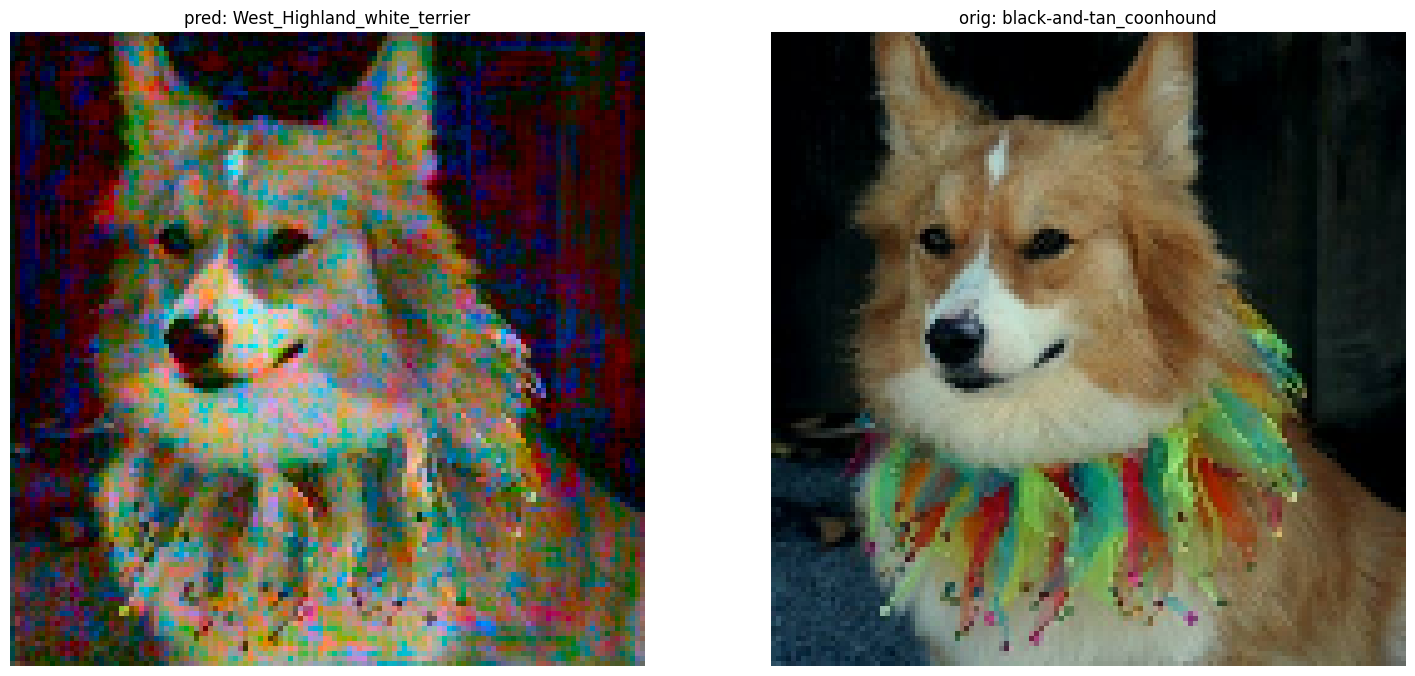

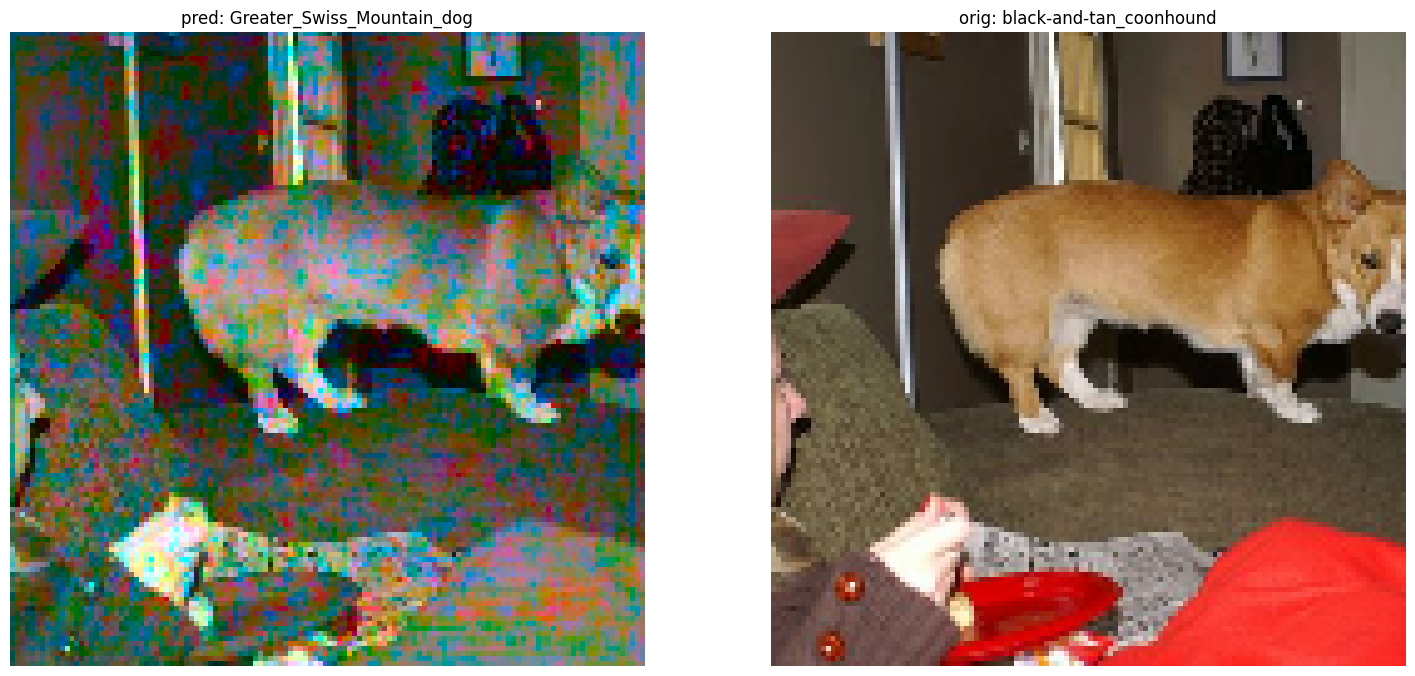

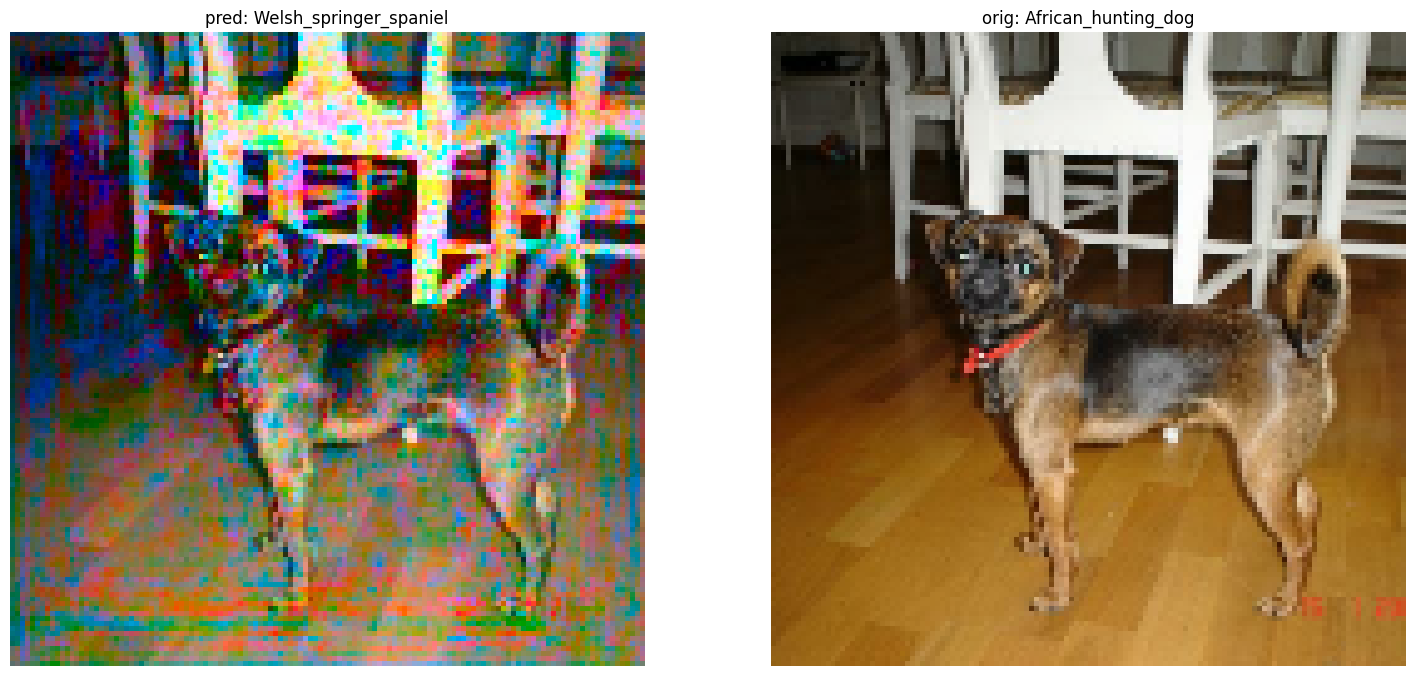

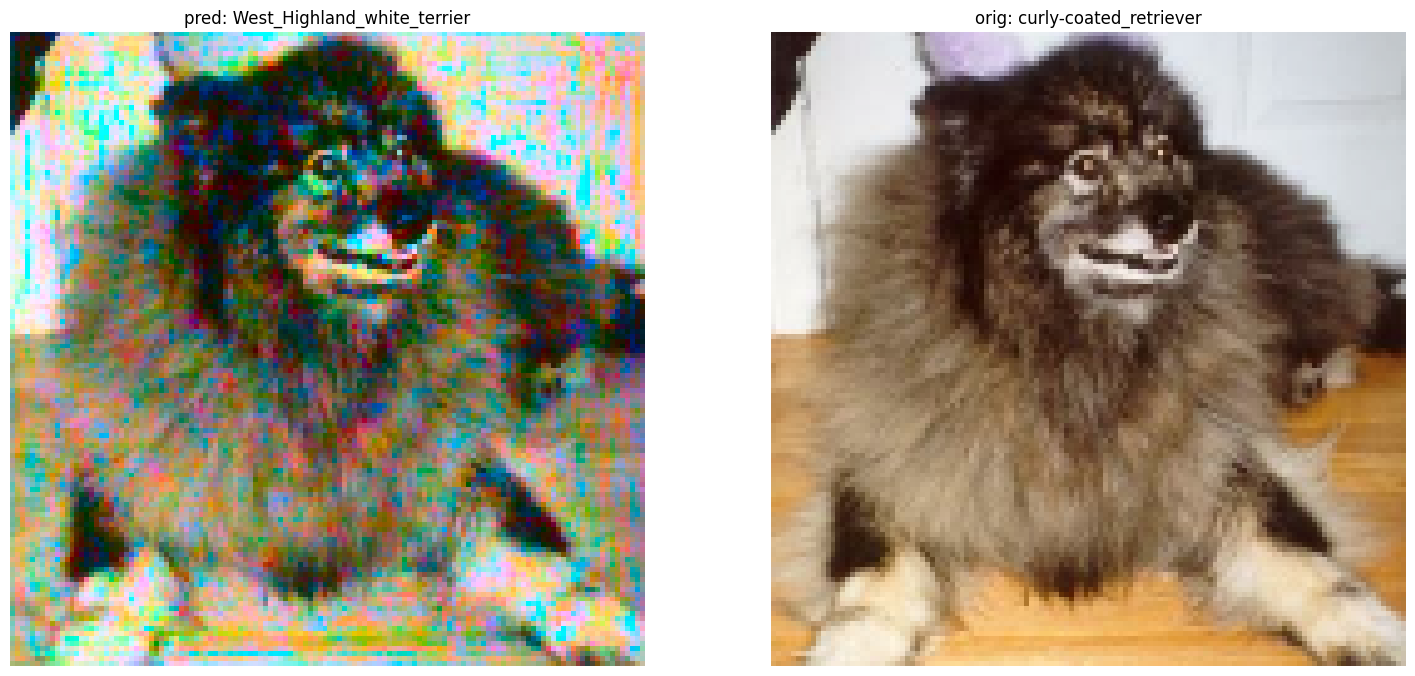

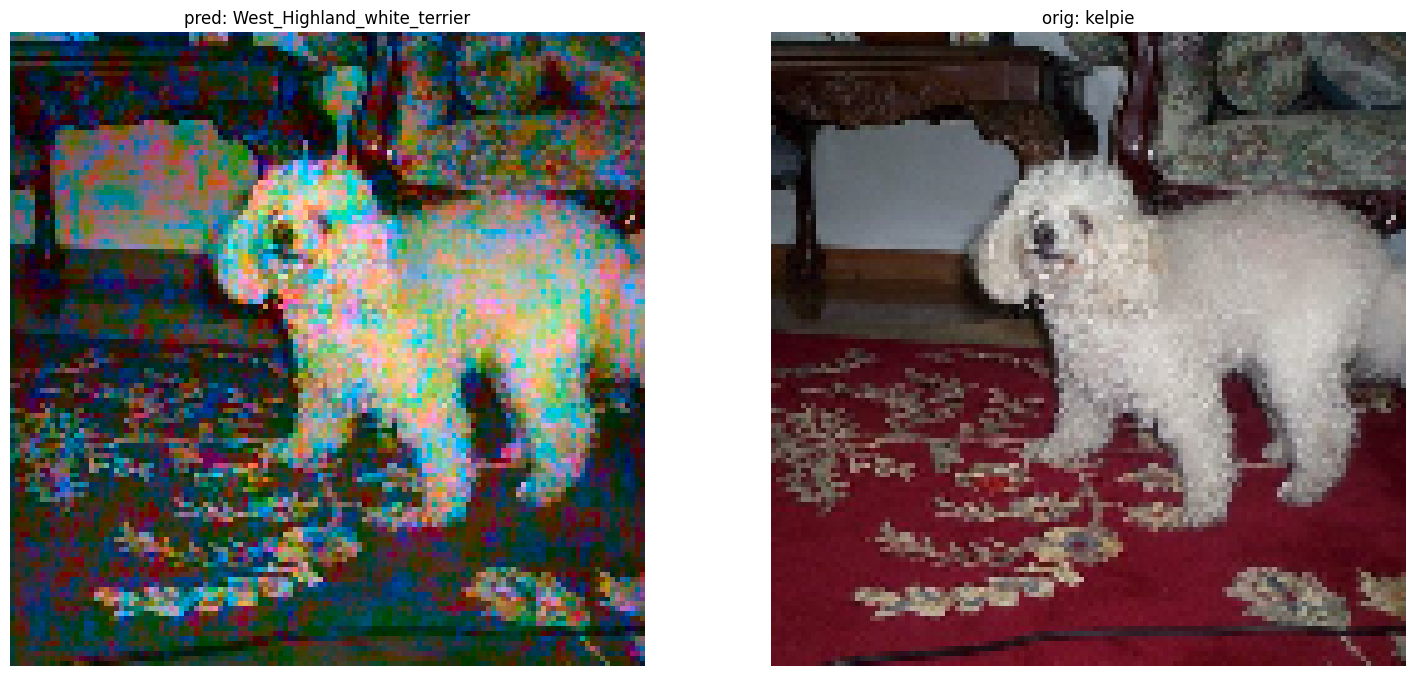

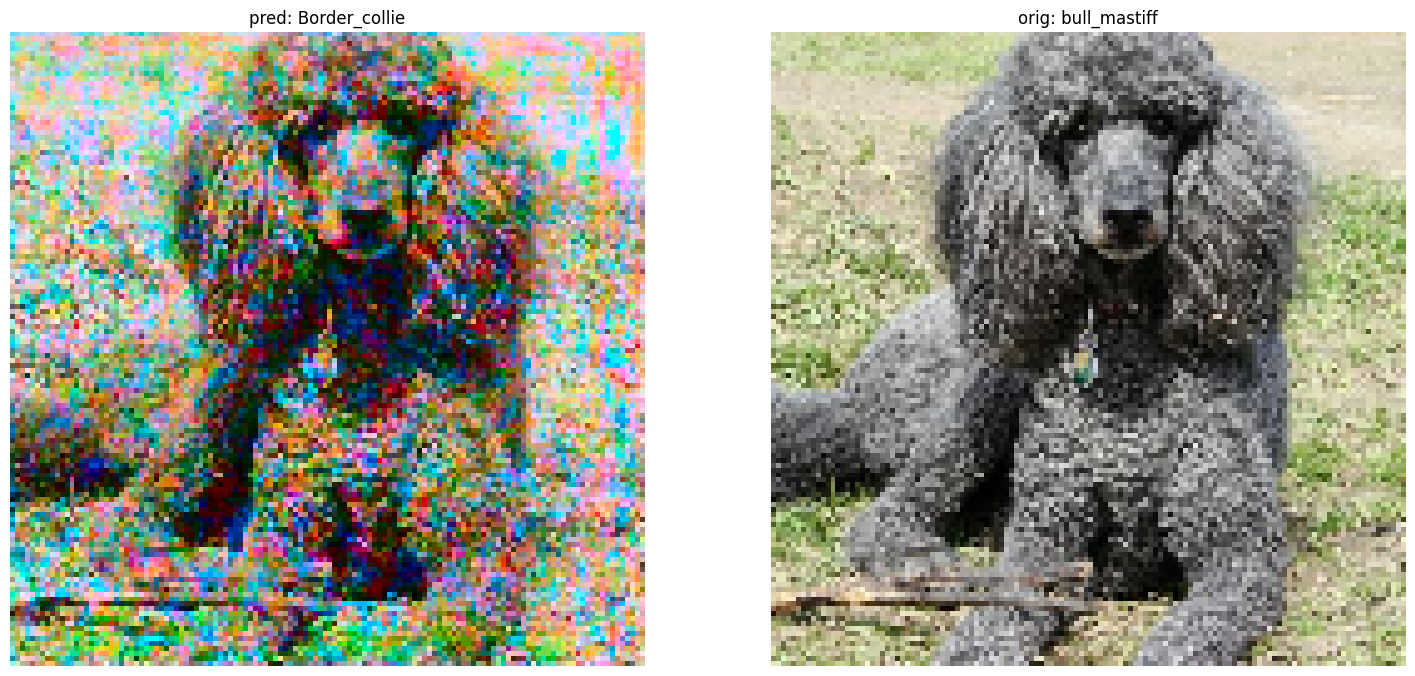

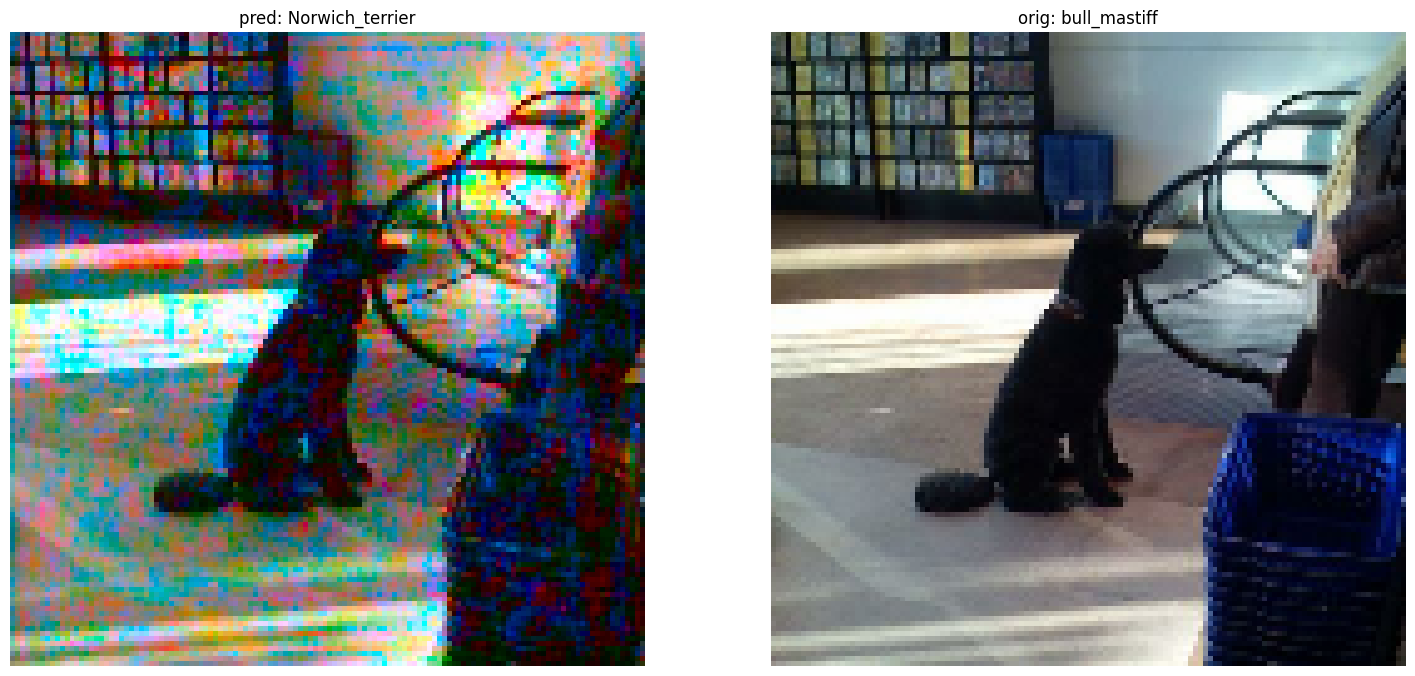

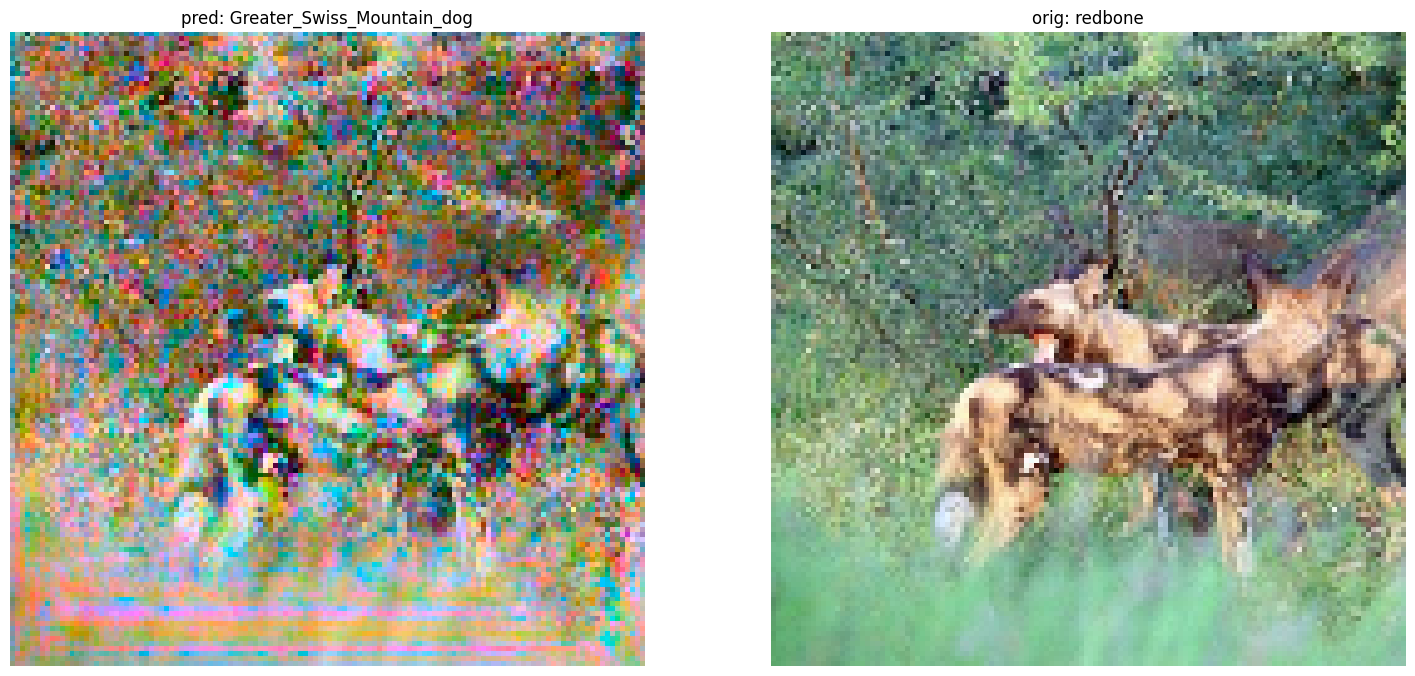

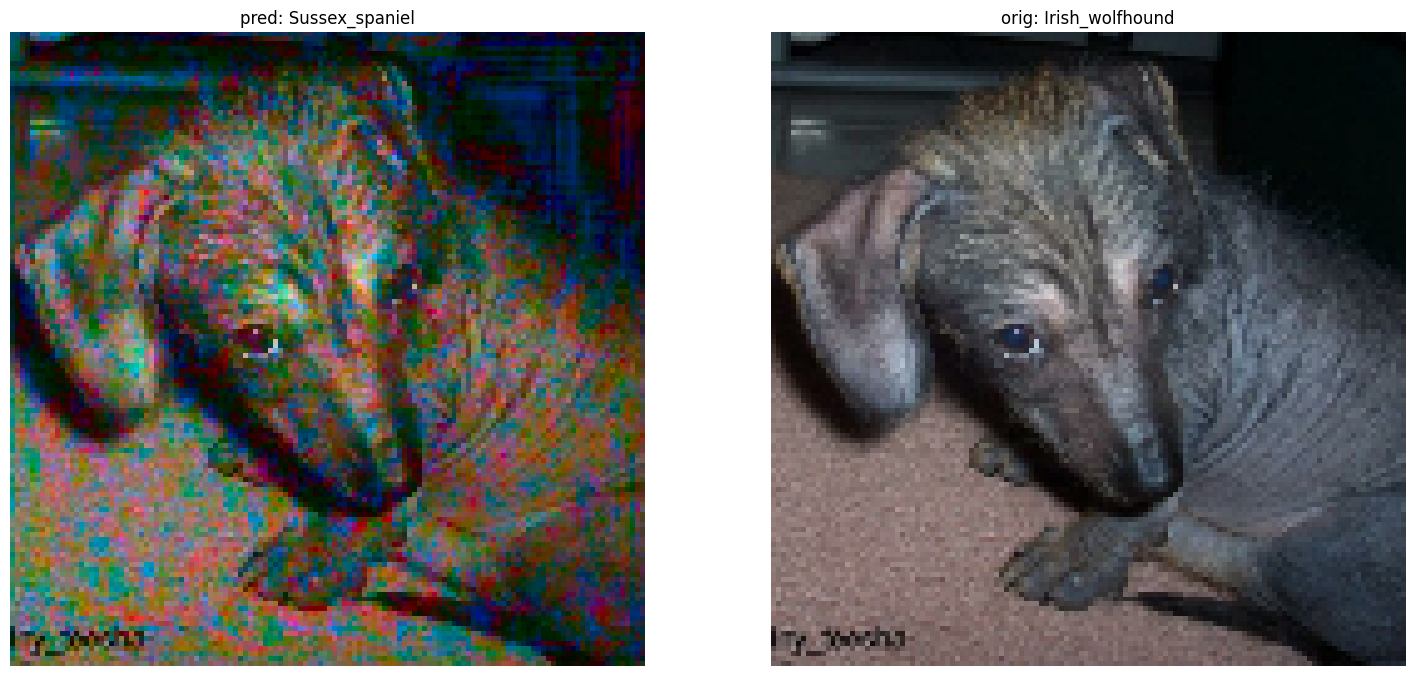

In [ ]:
for data in tqdm(test_data, position=0, leave=True):
    predicted_color, predicted_label = model.test_step(data)

#
    if random.random() < 0.2:
        visualize(predicted_color[0], predicted_label[0], data)


In [ ]:
%tensorboard --logdir logs